<a href="https://colab.research.google.com/github/IdaVillumsen/DL_algorithmicFairness/blob/main/Clean_DL_Algorithmic_Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Iniliziation

In [2]:
# Imports relevant libaries 
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import torchvision
import torch
import zipfile
import torch.optim as optim
import operator
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn import Linear, Conv2d, BatchNorm1d, MaxPool2d, Dropout
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from sklearn.metrics import *
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

# Import the dataloader used to split the data to train, validation and test set
import data_loader

%load_ext autoreload
%autoreload 2

In [3]:
# Connecter with google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzipping the folder with the images 
with zipfile.ZipFile("drive/My Drive/DL_project/img_align_celeba.zip","r") as zip_ref:
  zip_ref.extractall("images/")

# Loading and pre-processing

In [5]:
# Checking if all the images is loaded 
root = 'images/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


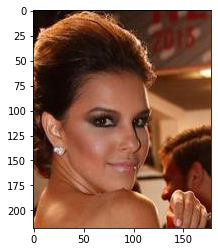

In [6]:
# Showing an image 
image = imread('images/img_align_celeba/065287.jpg') 
plt.imshow(image, cmap='gray')

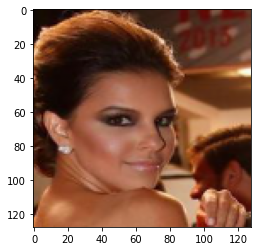

In [7]:
# Resize image
image = imread('images/img_align_celeba/065287.jpg') 
image_size = (128, 128)
image = resize(image,image_size)
plt.imshow(image, cmap='gray')

In [8]:
# Load attributes from the csv file in google drive 
Attributes = pd.read_csv('/content/drive/My Drive/DL_project/list_attributs.csv')
drive_path = 'drive/My Drive/DL_project/'

In [ ]:
# The different attributes in the dataset
Attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   img                  202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [ ]:
# Investigating the distribution of different attributes 
print("Percentage of females:", sum([Attributes["Male"] == -1]).value_counts(normalize = True)[1]*100)
print("Percentage of females who is attractive:", Attributes["Attractive"][Attributes["Male"] == -1].value_counts(normalize = True)[1]*100)
print("Percentage of males who is attractive:", Attributes["Attractive"][Attributes["Male"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of young people who is attractive:", Attributes["Attractive"][Attributes["Young"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of old people who is attractive:", Attributes["Attractive"][Attributes["Young"] == -1].value_counts(normalize = True)[1]*100)
print("Percentage of pople that are chubby who is attractive:", Attributes["Attractive"][Attributes["Chubby"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of people with pale skin and a big nose:", Attributes["Pale_Skin"][Attributes["Big_Nose"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of people who is attrative and has bushy eyebrows:", Attributes["Attractive"][Attributes["Bushy_Eyebrows"] == 1].value_counts(normalize = True)[1]*100)

Percentage of females: 58.32457218446291
Percentage of females who is attractive: 67.91689586595015
Percentage of males who is attractive: 27.925953999573633
Percentage of young people who is attractive: 61.73453111641379
Percentage of old people who is attractive: 15.423525564155675
Percentage of pople that are chubby who is attractive: 3.343908085398268
Percentage of people with pale skin and a big nose: 2.42023739372001
Percentage of people who is attrative and has bushy eyebrows: 56.44203728778252


In [9]:
# Calculating distribution of dataset
# Percent of male
perc_men = sum([Attributes["Male"] == 1]).value_counts(normalize = True)[1]*100
# Percent of attractive persons  
perc_attra = sum([Attributes["Attractive"] == 1]).value_counts(normalize = True)[1]*100
# Percent of attractive male
perc_attra_men = Attributes["Attractive"][Attributes["Male"] == 1].value_counts(normalize = True)[1]*100
# Percent of attractive females
perc_attra_women = Attributes["Attractive"][Attributes["Male"] == -1].value_counts(normalize = True)[1]*100

data=[perc_men,perc_attra,perc_attra_men,perc_attra_women]

In [10]:
# Defining image size
image_size = image.shape
# Defining the shape of image [heigth, width]
IMAGE_SHAPE = [image_size[0], image_size[1], 3]
# Defining the path to the folder containing the images 
IMAGE_PATHS = "images/img_align_celeba/"

In [11]:
## Splitting the data using dataloader ##

# Selecting only the attributes needed 
selec_attrs = ['Attractive','Male']
# defining the batch size for the network 
batch_size = 128

# Data loaders for the training, validation and test set
trainloader = data_loader.get_loader(image_dir=IMAGE_PATHS,
                                    attr_path=drive_path+"list_attr_celeba.txt",
                                    split_path=drive_path+"list_eval_partition.txt",
                                    selected_attrs=selec_attrs, 
                                    image_size=image_size[0],
                                    batch_size=batch_size, 
                                    dataset='CelebA', 
                                    mode='train', 
                                    num_workers=1)


validloader = data_loader.get_loader(image_dir=IMAGE_PATHS,
                                    attr_path=drive_path+"list_attr_celeba.txt",
                                    split_path=drive_path+"list_eval_partition.txt",
                                    selected_attrs=selec_attrs, 
                                    image_size=image_size[0],
                                    batch_size=batch_size, 
                                    dataset='CelebA', 
                                    mode='valid', 
                                    num_workers=1)

testloader = data_loader.get_loader(image_dir=IMAGE_PATHS,
                                    attr_path=drive_path+"list_attr_celeba.txt",
                                    split_path=drive_path+"list_eval_partition.txt",
                                    selected_attrs=selec_attrs, 
                                    image_size=image_size[0],
                                    batch_size=batch_size, 
                                    dataset='CelebA', 
                                    mode='test', 
                                    num_workers=1)

Finished preprocessing the CelebA dataset...
Finished preprocessing the CelebA dataset...
Finished preprocessing the CelebA dataset...


In [12]:
# calcualte the number of training, validation and test observations
train_obs = len(trainloader.dataset)
valid_obs = len(validloader.dataset)
test_obs = len(testloader.dataset)
print('Number of training observations is',train_obs)
print('Number of validation observations is',valid_obs)
print('Number of test observations is',test_obs)
print('Total number of observations is',train_obs+valid_obs+test_obs)

Number of training observations is 162770
Number of validation observations is 19867
Number of test observations is 19962
Total number of observations is 202599


In [13]:
# The output from the dataloaders 
for data in trainloader:
    print('Elements of list 1:')
    print('Batchsize =', len(data[0]))
    print('Number of channels =', len(data[0][0]))
    print('Height of image =', len(data[0][0][0]))
    print('Width of image =', len(data[0][0][0][0]))
    print('Elements of list 2:')
    print('Attribute: Attractive')
    print(torch.flatten(data[1]))
    break

Elements of list 1:
Batchsize = 128
Number of channels = 3
Height of image = 128
Width of image = 128
Elements of list 2:
Attribute: Attractive
tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],

tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0], dtype=torch.int32)


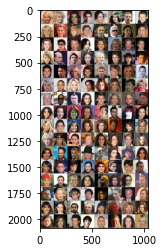

In [14]:
# Plotting one batch from the training loader
def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels, _ = iter(trainloader).next()

# show images
imshow(torchvision.utils.make_grid(images))

print(torch.flatten(labels))

# Define a CNN

In [15]:
# Setup for use of CUDA if it is avaible 
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [38]:
## hyperameters of the model ##

# The images shape
channels = images.shape[1]
height = images.shape[2]
width = images.shape[3]

# Convolution nr. 1 
num_filters_conv1 = 16
kernel_size_conv1 = 3 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 1

# Convolution nr. 2 
num_filters_conv2 = 16
kernel_size_conv2 = 5 # [height, width]
stride_conv2 = 1 # [stride_height, stride_width]
padding_conv2 = 2

# Convolution nr. 3
num_filters_conv3 = 32
kernel_size_conv3 = 3 # [height, width]
stride_conv3 = 1 # [stride_height, stride_width]
padding_conv3 = 1

# Convolution nr. 4 
num_filters_conv4 = 64
kernel_size_conv4 = 3 # [height, width]
stride_conv4 = 1 # [stride_height, stride_width]
padding_conv4 = 1

# Maxpolling 
kernel_pool = 2
stride_pool = 2

# Number of features for the linear layers 
num_l1 = 1024
num_l2 = 512
num_l3 = 64


def compute_dim(dim_size, kernel, padding, stride):
    # Calculate the dimension of filters 
    return int((dim_size - kernel + 2 * padding) / stride + 1)


# Define network
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # convolution layer 1
        self.conv1_1 = Conv2d(in_channels=channels,
                            out_channels=num_filters_conv1,
                            kernel_size=kernel_size_conv1,
                            stride=stride_conv1,
                            padding=padding_conv1)
        self.conv1_out_height = compute_dim(height, kernel_size_conv1, padding_conv1, stride_conv1)
        self.conv1_out_width = compute_dim(width, kernel_size_conv1, padding_conv1, stride_conv1)
              
        # max pooling of convolution layer 1
        self.pool = MaxPool2d(kernel_size=kernel_pool,
                       stride=stride_pool)
        self.pool1_out_height = compute_dim(self.conv1_out_height, kernel_pool, 0, stride_pool)
        self.pool1_out_width = compute_dim(self.conv1_out_width, kernel_pool, 0, stride_pool)

        # convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=num_filters_conv1,
                               out_channels=num_filters_conv2,
                               kernel_size=kernel_size_conv2,
                               stride=stride_conv2,
                               padding=padding_conv2)
        self.conv2_out_height = compute_dim(self.pool1_out_height, kernel_size_conv2, padding_conv2, stride_conv2)
        self.conv2_out_width = compute_dim(self.pool1_out_width, kernel_size_conv2, padding_conv2, stride_conv2)
        
        # calculate dimensions after max pooling of convolution layer 2
        self.pool2_out_height = compute_dim(self.conv2_out_height, kernel_pool, 0, stride_pool)
        self.pool2_out_width = compute_dim(self.conv2_out_width, kernel_pool, 0, stride_pool)

        # convolution layer 3
        self.conv3 = nn.Conv2d(in_channels=num_filters_conv2,
                               out_channels=num_filters_conv3,
                               kernel_size=kernel_size_conv3,
                               stride=stride_conv3,
                               padding=padding_conv3)
        self.conv3_out_height = compute_dim(self.pool2_out_height, kernel_size_conv3, padding_conv3, stride_conv3)
        self.conv3_out_width = compute_dim(self.pool2_out_width, kernel_size_conv3, padding_conv3, stride_conv3)
        
        # calculate dimensions max pooling of convolution layer 3
        self.pool3_out_height = compute_dim(self.conv3_out_height, kernel_pool, 0, stride_pool)
        self.pool3_out_width = compute_dim(self.conv3_out_width, kernel_pool, 0, stride_pool)
        
        # convolution layer 4
        self.conv4 = nn.Conv2d(in_channels=num_filters_conv3,
                               out_channels=num_filters_conv4,
                               kernel_size=kernel_size_conv4,
                               stride=stride_conv4,
                               padding=padding_conv4)
        self.conv4_out_height = compute_dim(self.pool3_out_height, kernel_size_conv4, padding_conv4, stride_conv4)
        self.conv4_out_width = compute_dim(self.pool3_out_width, kernel_size_conv4, padding_conv4, stride_conv4)
        
        # calculate dimensions max pooling of convolution layer 4
        self.pool4_out_height = compute_dim(self.conv4_out_height, kernel_pool, 0, stride_pool)
        self.pool4_out_width = compute_dim(self.conv4_out_width, kernel_pool, 0, stride_pool)


        # Linear layer 1
        self.l1_in_features = num_filters_conv4 * self.pool4_out_height * self.pool4_out_width 
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        # Batch normalization
        self.bn1 = BatchNorm1d(num_l1)

        # Linear layer 2 
        self.l_2 = Linear(in_features=num_l1, 
                            out_features=num_l2,
                            bias=True)
        # Batch normalization
        self.bn2 = BatchNorm1d(num_l2)

        # Linear layer 3
        self.l_3 = Linear(in_features=num_l2, 
                            out_features=num_l3,
                            bias=True)
        # Batch normalization 
        self.bn3 = BatchNorm1d(num_l3)
        
        # Linear layer and output 
        self.l_out = Linear(in_features=num_l3, 
                            out_features=2,
                            bias=False)
        
        # Dropout
        self.dropout = Dropout(p = 0.5)
        

    def forward(self, x):
        x = self.pool(relu(self.conv1_1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = self.pool(relu(self.conv3(x)))
        x = self.pool(relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(-1, self.l1_in_features)
        x = relu(self.bn1(self.l_1(x)))
        x = relu(self.bn2(self.l_2(x)))
        x = relu(self.bn3(self.l_3(x)))
        x = softmax(self.l_out(x))
        return x
    

net = Net(2)
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l_1): Linear(in_features=4096, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_3): Linear(in_features=512, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=64, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [39]:
# Define the loss function 
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Calculate the accuracy of the network 
def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [ ]:
# Defining the munber of epoch the network runs 
num_epoch = 10

# Initialize variables
count = 0
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        count += 1

        # get the inputs
        inputs, labels, _ = data
        labels = get_variable(torch.flatten(labels).type(torch.LongTensor))

        # forward + backward + optimize
        outputs = net(get_variable(Variable(inputs)))
        # Calculate the loss 
        loss = criterion(outputs, labels)
        #Saving the loss and accuracy
        train_loss.append(float(get_numpy(loss.detach())))
        train_accs.append(float(get_numpy(accuracy(outputs, labels).detach())))

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        # Plots updated for each epoch
        if count % 100 == 0:
            print('Epoch %d, batch number %5d, loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

            valid_iter.append(count)

            val_loss, val_acc, val_lengths = 0, 0, 0
            net.eval()
            with torch.no_grad():
                for j, data in enumerate(validloader):
                    num = len(data[0])
                    images, labels, _ = data
                    labels = get_variable(torch.flatten(labels[:,0]).type(torch.LongTensor))
                    outputs = net(get_variable(Variable(images)))
                    #labels_argmax = torch.max(outputs.data, 1)[1]
                    val_loss += criterion(outputs, labels)*num
                    val_acc += accuracy(outputs, labels)*num
                    val_lengths += num

            val_loss /= val_lengths
            val_acc /= val_lengths
            valid_loss.append(float(get_numpy(val_loss)))
            valid_accs.append(float(get_numpy(val_acc)))

            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(range(count), train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(range(count), train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            clear_output(wait=True)

print('Finished Training!')

In [ ]:
# Save model
#torch.save(Net, drive_path+'netDL.pkl')

In [40]:
# Load model
net = torch.load(drive_path+'netDL.pkl')

# Validation set 

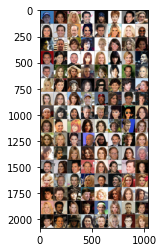

GroundTruth:
tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1], dtype=torch.int32)
Predicted:
tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [41]:
# Cheking the output from the network using the the validation set 
images, labels, _ = iter(validloader).next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:')
print(torch.flatten(labels[:,0]))

outputs = net(get_variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted:')
print(predicted)

In [42]:
# Evaluate the network on the validation set

# Initialize variables
correct = 0
total = 0
valid_filenames, valid_labels, valid_gender, valid_outputs = [], [], [], []

net.eval()
with torch.no_grad():
    for data in validloader:
        # load the data for the batch 
        images, labels, filename = data
        # saving the images names 
        valid_filenames += list(filename)
        # Saving the labels for attractive 
        valid_labels.extend(torch.flatten(labels[:,0]).tolist())
        # Saving the labels for gender 
        valid_gender.extend(torch.flatten(labels[:,1]).tolist())
        labels = torch.flatten(get_variable(labels[:,0]))
        # The networks prediction 
        outputs = net(get_variable(Variable(images)))
        valid_outputs.extend(torch.flatten(outputs[:,1]).tolist())
        # Changing the prediction to 0 or 1 with a threshold on 0.5 
        _, predicted = torch.max(outputs.data, 1)
        # Counting the number of images 
        total += labels.size(0)
        # Counting the correct predicted labels
        correct += (predicted == labels).sum()

print('Accuracy of the network on the {} validation images: {:4.2f} %'.format(
    valid_obs, 100 * correct.true_divide(total)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 19867 validation images: 78.06 %


Predicted attractiveness: 0.9999998807907104
Most attractive number 1
Gender: 0


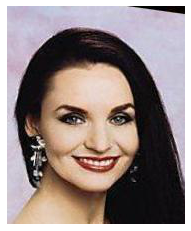

In [43]:
# The predicted most attractive image
sort_idx = np.flip(np.argsort(valid_outputs))

# show image
root = 'images/img_align_celeba/'
choose_idx = 0
image = imread(root+valid_filenames[sort_idx[choose_idx]]) 
plt.imshow(image, cmap='gray')
plt.axis('off')
print('Predicted attractiveness:', valid_outputs[sort_idx[choose_idx]])
print('Most attractive number', choose_idx+1)
print('Gender:', valid_gender[sort_idx[choose_idx]])

## Fairness Metrics

In [44]:
## Fairness metrics for threshold at 0.5 ## 
# Number of males and females:
num_male = sum(valid_gender)
num_female = len(valid_gender)-sum(valid_gender)

# Group Fairness 
d1_m, d1_f = 0, 0
att_d1_m, att_d1_f = 0, 0
for i in range(len(valid_gender)):
    if (valid_gender[i] == 1) and (valid_outputs[i] >= 0.5):
        d1_m = d1_m + 1
        if valid_labels[i] == 1:
            att_d1_m = att_d1_m + 1
    if (valid_gender[i] == 0) and (valid_outputs[i] >= 0.5):
        d1_f = d1_f + 1
        if valid_labels[i] == 1:
            att_d1_f = att_d1_f + 1
p_d1_m = d1_m/num_male
p_d1_f = d1_f/num_female
print('GROUP FAIRNESS')
print('P(d=1|G=m)=%.2f'%p_d1_m)
print('P(d=1|G=f)=%.2f'%p_d1_f)

# Predicted Parity
p_att_d1_m = att_d1_m/d1_m
p_att_d1_f = att_d1_f/d1_f
print('PREDICTED PARITY')
print('P(Y=1|d=1,G=m)=%.2f'%p_att_d1_m)
print('P(Y=1|d=1,G=f)=%.2f'%p_att_d1_f)

# Predictive Equality
num_unatt_male, num_unatt_female = 0, 0
d1_unatt_m, d1_unatt_f = 0, 0
for i in range(len(valid_gender)):
    if (valid_gender[i] == 1) and (valid_labels[i] == 0):
        num_unatt_male = num_unatt_male + 1
        if (valid_outputs[i] >= 0.5):
            d1_unatt_m = d1_unatt_m + 1
    if (valid_gender[i] == 0) and (valid_labels[i] == 0):
        num_unatt_female = num_unatt_female + 1
        if (valid_outputs[i] >= 0.5):
            d1_unatt_f = d1_unatt_f + 1
p_d1_unatt_m = d1_unatt_m/num_unatt_male
p_d1_unatt_f = d1_unatt_f/num_unatt_female
print('PREDICTIVE EQUALITY')
print('P(d=1|Y=0,G=m)=%.2f'%p_d1_unatt_m)
print('P(d=1|Y=0,G=f)=%.2f'%p_d1_unatt_f)

# Equalized Odd
num_att_male, num_att_female = 0, 0
d1_att_m, d1_att_f = 0, 0
for i in range(len(valid_gender)):
    if (valid_gender[i] == 1) and (valid_labels[i] == 1):
        num_att_male = num_att_male + 1
        if (valid_outputs[i] >= 0.5):
            d1_att_m = d1_att_m + 1
    if (valid_gender[i] == 0) and (valid_labels[i] == 1):
        num_att_female = num_att_female + 1
        if (valid_outputs[i] >= 0.5):
            d1_att_f = d1_att_f + 1
p_d1_att_m = d1_att_m/num_att_male
p_d1_att_f = d1_att_f/num_att_female
print('EQUALIZED ODDS')
print('P(d=1|Y=1,G=m)=%.2f'%p_d1_att_m)
print('P(d=1|Y=0,G=m)=%.2f'%p_d1_unatt_m)
print('P(d=1|Y=1,G=f)=%.2f'%p_d1_att_f)
print('P(d=1|Y=0,G=f)=%.2f'%p_d1_unatt_f)

GROUP FAIRNESS
P(d=1|G=m)=0.20
P(d=1|G=f)=0.73
PREDICTED PARITY
P(Y=1|d=1,G=m)=0.73
P(Y=1|d=1,G=f)=0.81
PREDICTIVE EQUALITY
P(d=1|Y=0,G=m)=0.08
P(d=1|Y=0,G=f)=0.42
EQUALIZED ODDS
P(d=1|Y=1,G=m)=0.47
P(d=1|Y=0,G=m)=0.08
P(d=1|Y=1,G=f)=0.88
P(d=1|Y=0,G=f)=0.42


### ROC 

In [ ]:
# Seperate outputs for male and female
indices_m = [i for i, x in enumerate(valid_gender) if x == 1]
indices_f = [i for i, x in enumerate(valid_gender) if x == 0]
# The outputs of network
valid_outputs_m = list(operator.itemgetter(*indices_m)(valid_outputs))
valid_outputs_f = list(operator.itemgetter(*indices_f)(valid_outputs))
# The ground thruth labels 
valid_labels_m = list(operator.itemgetter(*indices_m)(valid_labels))
valid_labels_f = list(operator.itemgetter(*indices_f)(valid_labels))

# Determine TPR and FPR for multiple thresholds for male and female 
fpr_m, tpr_m, thresholds_m = roc_curve(valid_labels_m, valid_outputs_m, pos_label=1)
fpr_f, tpr_f, thresholds_f = roc_curve(valid_labels_f, valid_outputs_f, pos_label=1)

In [ ]:
# Finding the where the two ROC curves intersect with a small tolerance in the values for FPR and TPR 

# Tolerance 
tol = 0.00005
# Initialize variables
thres_f, thres_m, tpr, fpr = [], [], [], []

for i in range(len(fpr_f)):
    for j in range(len(fpr_m)):
        if fpr_f[i] < (fpr_m[j]+tol) and fpr_f[i] > (fpr_m[j]-tol) and \
         tpr_f[i] < (tpr_m[j]+tol) and tpr_f[i] > (tpr_m[j]-tol) and \
         fpr_m[j] < 0.3 and fpr_m[j] > 0.1:
            thres_f.append(thresholds_f[i])
            thres_m.append(thresholds_m[j])
            fpr.append(fpr_f[i])
            tpr.append(tpr_f[i])

print('The two curves interset at TPR are ',tpr,'and FPR are',fpr)

The two curves interset at TPR are  [0.6103371956776461] and FPR are [0.13143776824034334]


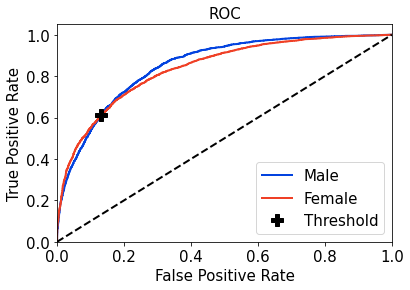

In [ ]:
# Plotting the two ROC curves 
roc_plot = plt.figure()
lw = 2
plt.rcParams['font.size'] = '15'
plt.plot(fpr_m, tpr_m, color='xkcd:blue',
         lw=lw, label='Male')#'ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr_f, tpr_f, color='xkcd:tomato',
         lw=lw, label='Female')#'ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.plot([np.mean(fpr)], [np.mean(tpr)],'P', markersize=12, color="black", label='Threshold')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('ROC',fontsize=15)
plt.legend(loc="lower right")
plt.show()
# saving the plot to google drive 
#roc_plot.savefig(drive_path+'roc.png', dpi=500, bbox_inches='tight')

# Test set

In [ ]:
# Running the test set through the network

# Initialize variables
correct = 0
total = 0
test_filenames, test_labels, test_gender, test_outputs = [], [], [], []

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels, filename = data
        test_filenames += list(filename)
        test_labels.extend(torch.flatten(labels[:,0]).tolist())
        test_gender.extend(torch.flatten(labels[:,1]).tolist())
        labels = torch.flatten(get_variable(labels[:,0]))
        outputs = net(get_variable(Variable(images)))
        test_outputs.extend(torch.flatten(outputs[:,1]).tolist())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Predicted attractiveness: 0.9999997615814209
Most attractive number 1
Gender: 0


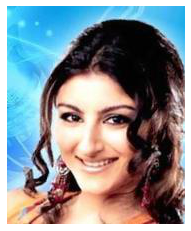

In [ ]:
# The predicted most attractive image
sort_idx = np.flip(np.argsort(test_outputs))

# show images
root = 'images/img_align_celeba/'
choose_idx = 0
image = imread(root+test_filenames[sort_idx[choose_idx]]) 
plt.imshow(image, cmap='gray')
plt.axis('off')
print('Predicted attractiveness:', test_outputs[sort_idx[choose_idx]])
print('Most attractive number', choose_idx+1)
print('Gender:', test_gender[sort_idx[choose_idx]])

In [ ]:
# Splitting the test set into male and felmale 
indices_m = [i for i, x in enumerate(test_gender) if x == 1]
indices_f = [i for i, x in enumerate(test_gender) if x == 0]
# Splitting the outputs for the networks predictions 
test_outputs_m = list(operator.itemgetter(*indices_m)(test_outputs))
test_outputs_f = list(operator.itemgetter(*indices_f)(test_outputs))
# Splitting the ground truth 
test_labels_m = list(operator.itemgetter(*indices_m)(test_labels))
test_labels_f = list(operator.itemgetter(*indices_f)(test_labels))

In [ ]:
# Calculate the accuracy of the network with a threshold on 0.5 
test_pred_m_old = test_outputs_m > np.mean(0.5)
test_pred_f_old = test_outputs_f > np.mean(0.5)
correct_m_old = (test_pred_m_old == test_labels_m).sum()
correct_f_old = (test_pred_f_old == test_labels_f).sum()

print('Accuracy of the network with threshold 0.5 on the {} male test images: {:4.2f} %'.format(
     len(indices_m), 100 * correct_m_old/len(indices_m)))
print('Accuracy of the network with threshold 0.5 on the {} female test images: {:4.2f} %'.format(
     len(indices_f), 100 * correct_f_old/(len(indices_f))))
print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    test_obs, 100 * correct.true_divide(total)))

Accuracy of the network with threshold 0.5 on the 7715 male test images: 82.31 %
Accuracy of the network with threshold 0.5 on the 12247 female test images: 77.63 %
Accuracy of the network on the 19962 test images: 79.44 %


In [ ]:
# Calculating the accuracy for the new thresholds for male and female
test_pred_m = test_outputs_m > np.mean(thres_m)
test_pred_f = test_outputs_f > np.mean(thres_f)
correct_m = (test_pred_m == test_labels_m).sum()
correct_f = (test_pred_f == test_labels_f).sum()

print('Accuracy of the network with threshold {} on the {} male test images: {:4.2f} %'.format(
    np.mean(thres_m), len(indices_m), 100 * correct_m/len(indices_m)))
print('Accuracy of the network with threshold {} on the {} female test images: {:4.2f} %'.format(
    np.mean(thres_f), len(indices_f), 100 * correct_f/(len(indices_f))))
print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(indices_f), 100 * (correct_f+correct_m)/(len(indices_f)+len(indices_m))))

Accuracy of the network with threshold 0.20271970331668854 on the 7715 male test images: 81.98 %
Accuracy of the network with threshold 0.9779426455497742 on the 12247 female test images: 68.75 %
Accuracy of the network on the 12247 test images: 73.87 %


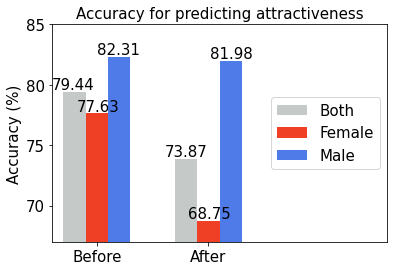

In [ ]:
# Plotting hte accuracy for the test set before and after the new threshold 
data = [[(100 * correct.true_divide(total)).data.tolist(), 100 * ((correct_f+correct_m)/(len(indices_f)+len(indices_m)))],
        [100 * correct_f_old/len(indices_f),100 * correct_f/len(indices_f)],
        [ 100 * correct_m_old/len(indices_m), 100 * correct_m/len(indices_m)]]

# create plot
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.2

plt.rcParams['font.size'] = '15'
plt.text(0-0.20, data[0][0]+0.2, str(round(data[0][0],2)))
plt.text(1-0.19, data[0][1]+0.2, str(round(data[0][1],2)))
plt.text(0.02, data[1][0]+0.2, str(round(data[1][0],2)))
plt.text(1.02, data[1][1]+0.2, str(round(data[1][1],2)))
plt.text(0.2, data[2][0]+0.2, str(round(data[2][0],2)))
plt.text(1+0.21, data[2][1]+0.2, str(round(data[2][1],2)))

test_size = 15
plt.bar(index, data[0], bar_width, color = 'xkcd:silver', label='Both')
plt.bar(index + bar_width, data[1], bar_width, color='xkcd:tomato', label = 'Female')
plt.bar(index + bar_width*2, data[2], bar_width, color = 'xkcd:blue',alpha=0.7, label ='Male')

plt.ylabel('Accuracy (%)',fontsize=test_size)
plt.title('Accuracy for predicting attractiveness',fontsize=test_size)
plt.xticks(index + bar_width, ('Before', 'After'),fontsize=test_size)
plt.ylim(67,85) 
plt.xlim(-0.2,2.8)
plt.legend(loc=5)

plt.show()
# Saving the figure to google drive 
#fig.savefig(drive_path+'hist.png', dpi=500)

## Fairness metrics

### Initial threshold

In [ ]:
## Fairness metrices for the threshold at 0.5  ##

# Number of males and females:
num_male = sum(test_gender)
num_female = len(test_gender)-sum(test_gender)

# Group Fairness
d1_m, d1_f = 0, 0
att_d1_m, att_d1_f = 0, 0
for i in range(len(test_gender)):
    if (test_gender[i] == 1) and (test_outputs[i] >= 0.5):
        d1_m = d1_m + 1
        if test_labels[i] == 1:
            att_d1_m = att_d1_m + 1
    if (test_gender[i] == 0) and (test_outputs[i] >= 0.5):
        d1_f = d1_f + 1
        if test_labels[i] == 1:
            att_d1_f = att_d1_f + 1
p_d1_m = d1_m/num_male
p_d1_f = d1_f/num_female
print('GROUP FAIRNESS')
print('P(d=1|G=m)=%.2f'%p_d1_m)
print('P(d=1|G=f)=%.2f'%p_d1_f)

# Predicted Parity
p_att_d1_m = att_d1_m/d1_m
p_att_d1_f = att_d1_f/d1_f
print('PREDICTED PARITY')
print('P(Y=1|d=1,G=m)=%.2f'%p_att_d1_m)
print('P(Y=1|d=1,G=f)=%.2f'%p_att_d1_f)

# Predictive Equality
num_unatt_male, num_unatt_female = 0, 0
d1_unatt_m, d1_unatt_f = 0, 0
for i in range(len(test_gender)):
    if (test_gender[i] == 1) and (test_labels[i] == 0):
        num_unatt_male = num_unatt_male + 1
        if (test_outputs[i] >= 0.5):
            d1_unatt_m = d1_unatt_m + 1
    if (test_gender[i] == 0) and (test_labels[i] == 0):
        num_unatt_female = num_unatt_female + 1
        if (test_outputs[i] >= 0.5):
            d1_unatt_f = d1_unatt_f + 1
p_d1_unatt_m = d1_unatt_m/num_unatt_male
p_d1_unatt_f = d1_unatt_f/num_unatt_female
print('PREDICTIVE EQUALITY')
print('P(d=1|Y=0,G=m)=%.2f'%p_d1_unatt_m)
print('P(d=1|Y=0,G=f)=%.2f'%p_d1_unatt_f)

# Equalized Odd
num_att_male, num_att_female = 0, 0
d1_att_m, d1_att_f = 0, 0
for i in range(len(test_gender)):
    if (test_gender[i] == 1) and (test_labels[i] == 1):
        num_att_male = num_att_male + 1
        if (test_outputs[i] >= 0.5):
            d1_att_m = d1_att_m + 1
    if (test_gender[i] == 0) and (test_labels[i] == 1):
        num_att_female = num_att_female + 1
        if (test_outputs[i] >= 0.5):
            d1_att_f = d1_att_f + 1
p_d1_att_m = d1_att_m/num_att_male
p_d1_att_f = d1_att_f/num_att_female
print('EQUALIZED ODDS')
print('P(d=1|Y=1,G=m)=%.2f'%p_d1_att_m)
print('P(d=1|Y=0,G=m)=%.2f'%p_d1_unatt_m)
print('P(d=1|Y=1,G=f)=%.2f'%p_d1_att_f)
print('P(d=1|Y=0,G=f)=%.2f'%p_d1_unatt_f)

GROUP FAIRNESS
P(d=1|G=m)=0.18
P(d=1|G=f)=0.70
PREDICTED PARITY
P(Y=1|d=1,G=m)=0.69
P(Y=1|d=1,G=f)=0.81
PREDICTIVE EQUALITY
P(d=1|Y=0,G=m)=0.08
P(d=1|Y=0,G=f)=0.39
EQUALIZED ODDS
P(d=1|Y=1,G=m)=0.52
P(d=1|Y=0,G=m)=0.08
P(d=1|Y=1,G=f)=0.86
P(d=1|Y=0,G=f)=0.39


### Fair threshold 

In [ ]:
## Fairness metrics for the new fair threshold ## 

# Number of males and females:
num_male = sum(test_gender)
num_female = len(test_gender)-sum(test_gender)

# Group Fairness
d1_m, d1_f = 0, 0
att_d1_m, att_d1_f = 0, 0
for i in range(len(test_gender)):
    if (test_gender[i] == 1) and (test_outputs[i] >= np.mean(thres_m)):
        d1_m = d1_m + 1
        if test_labels[i] == 1:
            att_d1_m = att_d1_m + 1
    if (test_gender[i] == 0) and (test_outputs[i] >= np.mean(thres_f)):
        d1_f = d1_f + 1
        if test_labels[i] == 1:
            att_d1_f = att_d1_f + 1
p_d1_m = d1_m/num_male
p_d1_f = d1_f/num_female
print('GROUP FAIRNESS')
print('P(d=1|G=m)=%.2f'%p_d1_m)
print('P(d=1|G=f)=%.2f'%p_d1_f)

# Predicted Parity
p_att_d1_m = att_d1_m/d1_m
p_att_d1_f = att_d1_f/d1_f
print('PREDICTED PARITY')
print('P(Y=1|d=1,G=m)=%.2f'%p_att_d1_m)
print('P(Y=1|d=1,G=f)=%.2f'%p_att_d1_f)

# Predictive Equality
num_unatt_male, num_unatt_female = 0, 0
d1_unatt_m, d1_unatt_f = 0, 0
for i in range(len(test_gender)):
    if (test_gender[i] == 1) and (test_labels[i] == 0):
        num_unatt_male = num_unatt_male + 1
        if (test_outputs[i] >= np.mean(thres_m)):
            d1_unatt_m = d1_unatt_m + 1
    if (test_gender[i] == 0) and (test_labels[i] == 0):
        num_unatt_female = num_unatt_female + 1
        if (test_outputs[i] >= np.mean(thres_f)):
            d1_unatt_f = d1_unatt_f + 1
p_d1_unatt_m = d1_unatt_m/num_unatt_male
p_d1_unatt_f = d1_unatt_f/num_unatt_female
print('PREDICTIVE EQUALITY')
print('P(d=1|Y=0,G=m)=%.2f'%p_d1_unatt_m)
print('P(d=1|Y=0,G=f)=%.2f'%p_d1_unatt_f)

# Equalized Odd
num_att_male, num_att_female = 0, 0
d1_att_m, d1_att_f = 0, 0
for i in range(len(test_gender)):
    if (test_gender[i] == 1) and (test_labels[i] == 1):
        num_att_male = num_att_male + 1
        if (test_outputs[i] >= np.mean(thres_m)):
            d1_att_m = d1_att_m + 1
    if (test_gender[i] == 0) and (test_labels[i] == 1):
        num_att_female = num_att_female + 1
        if (test_outputs[i] >= np.mean(thres_f)):
            d1_att_f = d1_att_f + 1
p_d1_att_m = d1_att_m/num_att_male
p_d1_att_f = d1_att_f/num_att_female
print('EQUALIZED ODDS')
print('P(d=1|Y=1,G=m)=%.2f'%p_d1_att_m)
print('P(d=1|Y=0,G=m)=%.2f'%p_d1_unatt_m)
print('P(d=1|Y=1,G=f)=%.2f'%p_d1_att_f)
print('P(d=1|Y=0,G=f)=%.2f'%p_d1_unatt_f)

GROUP FAIRNESS
P(d=1|G=m)=0.26
P(d=1|G=f)=0.42
PREDICTED PARITY
P(Y=1|d=1,G=m)=0.63
P(Y=1|d=1,G=f)=0.91
PREDICTIVE EQUALITY
P(d=1|Y=0,G=m)=0.13
P(d=1|Y=0,G=f)=0.11
EQUALIZED ODDS
P(d=1|Y=1,G=m)=0.66
P(d=1|Y=0,G=m)=0.13
P(d=1|Y=1,G=f)=0.58
P(d=1|Y=0,G=f)=0.11
